In [78]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scout import io
from scout import utils

SyntaxError: invalid syntax (<ipython-input-78-b641e4b3bd1e>, line 2)

In [79]:
%matplotlib notebook

In [3]:
parent_dir = '/media/jswaney/SSD EVO 860/organoid_phenotyping'
folder_name = '20190430_11_36_09_AA-4.30.19-org1_488LP12p5_561LP120_642LP50'
# parent_dir = '/media/jswaney/Drive/Justin/organoid_phenotyping'
# folder_name = '20190419_14_35_07_AA_org1_488LP13_561LP120_642LP60'
working_dir = '/data/datasets/organoid_phenotyping/d35_vs_d60/d35/20190419_14_35_07_AA_org1_488LP13_561LP120_642LP60/'
os.listdir(working_dir)

['syto.zarr',
 'Ex0_hist.csv',
 'Ex2_hist.csv',
 'nuclei_binary.zarr',
 'nuclei_probability.zarr',
 'nuclei_fluorescence',
 'segment_ventricles.tif',
 'face_labels.csv',
 'org1_ventricles.gif',
 'mesh.obj',
 'Ex2_rescaled',
 'nuclei_morphologies.csv',
 'syto_down6x',
 'organoid_features.xlsx',
 'points.obj',
 'syto_down6x.tif',
 'singlecell_morphology.pdf',
 'subpopulation_MidTBR1.obj',
 'points_sox2.obj',
 'niche_labels.npy',
 'Ex1_hist.csv',
 'subpopulation_SOX2.obj',
 'Ex_2_Em_2_destriped_stitched',
 'subpopulation_DP.obj',
 'cyto_profiles.npy',
 'points_dn_2.obj',
 'mesh.ply',
 'nuclei_foreground.zarr',
 'celltype_names.csv',
 'subpopulation_MidInter.obj',
 'centroids.npy',
 'points_sox2_2.obj',
 'nuclei_gating.npy',
 'cyto_profiles_sample.npy',
 'points_dn.obj',
 'sox2.zarr',
 'niche_names.csv',
 'Ex_1_Em_1_destriped_stitched',
 'subpopulation_DN.obj',
 'voxel_size.csv',
 'mesh_ventricles.pkl',
 'points_tbr1.obj',
 'nuclei_segmentations.npz',
 'tbr1.zarr',
 'cyto_labels.npy',
 'su

In [4]:
seg = np.load(os.path.join(working_dir, 'nuclei_segmentations.npz'))['arr_0']
seg.shape

(2173528, 16, 32, 32)

<IPython.core.display.Javascript object>


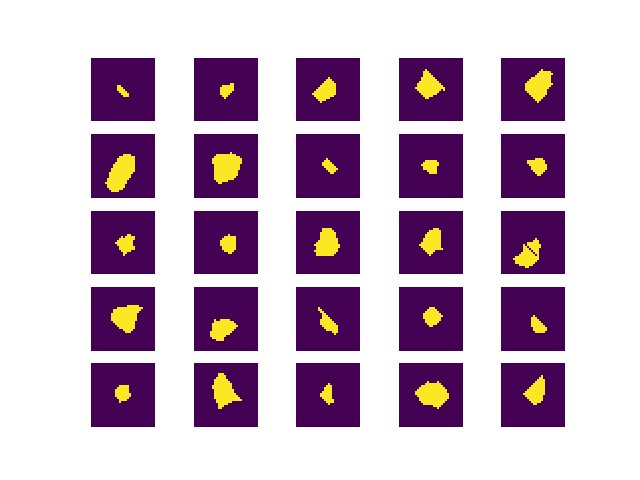

In [5]:
n = 5

idx = np.arange(len(seg))
np.random.shuffle(idx)
idx = idx[:n**2]

for k, i in enumerate(idx):
    img = seg[i, 8]
    plt.subplot(n, n, k+1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [12]:
prob = io.open(os.path.join(working_dir, 'nuclei_probability.zarr'))
prob.shape

(900, 3794, 3794)

In [13]:
centroids = np.load(os.path.join(working_dir, 'centroids.npy'))
centroids.shape

(1702545, 3)

<IPython.core.display.Javascript object>


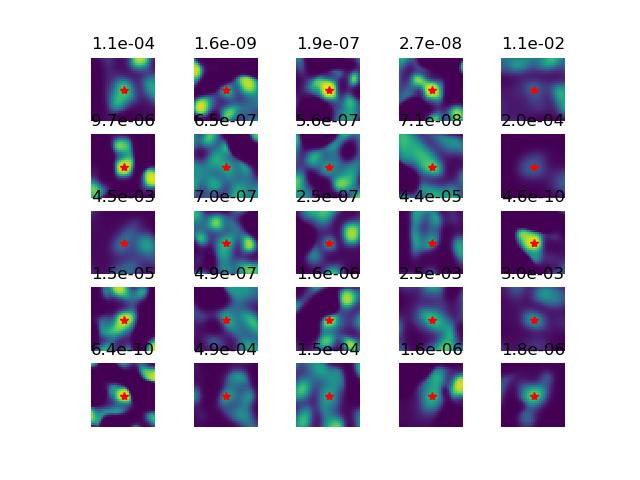

In [15]:
shape = np.asarray(seg.shape[1:])
for k, i in enumerate(idx):
    center = centroids[i]
    start = center - shape // 2
    stop = center + shape // 2
    img = utils.extract_box(prob, start, stop)[shape[0] // 2]
    plt.subplot(n, n, k+1)
    plt.imshow(img, clim=[0, 1])
    plt.plot([shape[2] // 2], [shape[1] // 2], 'r*')
    plt.title(f'{img.min():.1e}')
    plt.axis('off')
plt.show()

In [80]:
mask = io.open(os.path.join(working_dir, 'nuclei_foreground.zarr'))

<IPython.core.display.Javascript object>


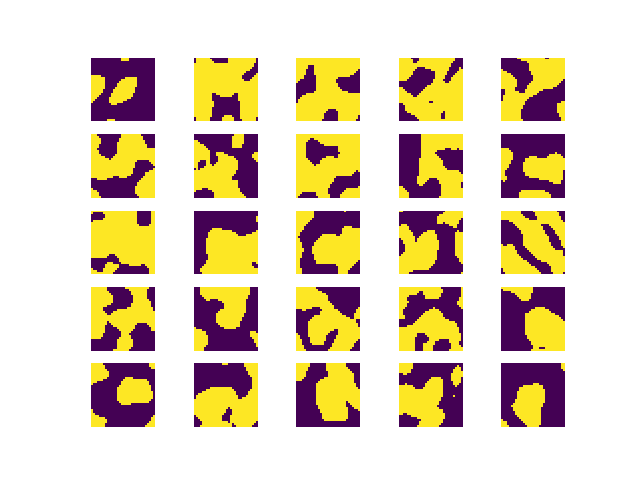

In [81]:
shape = np.asarray(seg.shape[1:])
for k, i in enumerate(idx):
    center = centroids[i]
    start = center - shape // 2
    stop = center + shape // 2
    img = utils.extract_box(mask, start, stop)[shape[0] // 2]
    plt.subplot(n, n, k+1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

Sort by PCA

In [451]:
from scout.utils import read_csv
from scout.cyto import randomly_sample
from sklearn.decomposition import PCA

In [488]:
celltype_names = read_csv(os.path.join(working_dir, 'celltype_names.csv'))
celltype_names

['sox2', 'tbr1', 'dn']

In [489]:
labels = np.load(os.path.join(working_dir, 'nuclei_gating.npy'))
labels.shape

(2173528, 2)

In [722]:
# Select particular label and repeat PCA
celltype = 'sox2'

if celltype == 'dn':
    label_idx = np.where(np.logical_and(labels[:, 0] == 0, labels[:, 1] == 1))[0]
elif celltype == 'tbr1':
    label_idx = np.where(labels[:, 1] == 1)[0]
elif celltype == 'sox2':
    label_idx = np.where(labels[:, 0] == 1)[0]
    
seg_celltype = seg[label_idx]
seg_celltype.shape

(923565, 16, 32, 32)

In [723]:
n = 10_000

np.random.seed(1)
(X,), random_idx = randomly_sample(n, seg_celltype, return_idx=True)
sample_idx = label_idx[random_idx]
X.shape

(10000, 16, 32, 32)

In [724]:
X = X.reshape((n, -1))
pca = PCA(n_components=1).fit(X)
sum(pca.explained_variance_ratio_)
x_pca = pca.transform(X)
x_pca.shape

(10000, 1)

In [725]:
idx = np.argsort(x_pca[:, 0])
X_sorted = X[idx].reshape((n, 16, 32, 32))
X_sorted.shape

(10000, 16, 32, 32)

In [710]:
# DN
start = 210
stop = 7000
nb_imgs = 5
i = np.linspace(start, stop-1, nb_imgs).astype(np.int)
imgs = X_sorted[i]
imgs.shape

(5, 16, 32, 32)

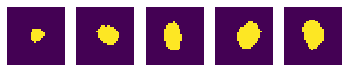

In [711]:
%matplotlib inline
for k, img in enumerate(imgs):
    plt.subplot(1, nb_imgs, k+1)
    plt.imshow(img.max(axis=0))
    plt.axis('off')
plt.show()

In [717]:
# TBR1
start = 201
stop = 9400
nb_imgs = 5
i = np.linspace(start, stop-1, nb_imgs).astype(np.int)
imgs = X_sorted[i]
imgs.shape

(5, 16, 32, 32)

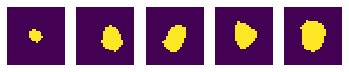

In [718]:
%matplotlib inline
for k, img in enumerate(imgs):
    plt.subplot(1, nb_imgs, k+1)
    plt.imshow(img.max(axis=0))
    plt.axis('off')
plt.show()

In [726]:
# SOX2
start = 500
stop = 8862
nb_imgs = 5
i = np.linspace(start, stop-1, nb_imgs).astype(np.int)
imgs = X_sorted[i]
imgs.shape

(5, 16, 32, 32)

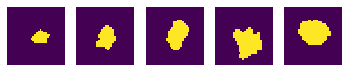

In [727]:
%matplotlib inline
for k, img in enumerate(imgs):
    plt.subplot(1, nb_imgs, k+1)
    plt.imshow(img.max(axis=0))
    plt.axis('off')
plt.show()

In [700]:
# Save mesh and syto ROI
from skimage.measure import marching_cubes_lewiner
from scout.cyto import write_obj
from scout.utils import read_voxel_size
from scout import io
from scout import utils
from skimage import img_as_uint

In [728]:
voxel_size = read_voxel_size(os.path.join(working_dir, 'voxel_size.csv'))

In [702]:
for k, img in enumerate(imgs):
    verts, faces, normals, values = marching_cubes_lewiner(img, spacing=voxel_size)
    filename = f'{celltype}_nucleus_{k}.obj'
    write_obj(os.path.join(working_dir, '..', filename), verts, faces, normals, values, one=True)

File written 30%
File written 60%
File written 30%
File written 60%
File written 30%
File written 60%
File written 30%
File written 60%
File written 30%
File written 60%


In [719]:
syto = io.open(os.path.join(working_dir, 'syto.zarr'))
syto.shape

(1500, 3799, 3799)

In [729]:
centroids = np.load(os.path.join(working_dir, 'centroids.npy'))
centroids_sample = centroids[sample_idx]
centers = centroids_sample[i]
centers

array([[1017, 2253, 1490],
       [ 921, 1653,  894],
       [ 653,  877, 2755],
       [ 452, 1068, 2531],
       [ 575, 2250, 1134]])

In [705]:
# Syto Images
starts = centers - np.asarray(X_sorted.shape[1:]) // 2
stops = centers + np.asarray(X_sorted.shape[1:]) // 2
for k, (start, stop) in enumerate(zip(starts, stops)):
    roi = utils.extract_box(syto, start, stop)
    roi = img_as_uint(roi)
    filename = f'{celltype}_nucleus_{k}.tif'
    io.imsave(os.path.join(working_dir, '..', filename), roi)

/home/jswaney/.conda/envs/scout/lib/python3.6/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float32 to uint16
  .format(dtypeobj_in, dtypeobj_out))


In [730]:
# Segmentations
for k, img in enumerate(imgs):
    filename = f'{celltype}_nucleus_{k}_seg.tif'
    io.imsave(os.path.join(working_dir, '..', filename), img)